# Train GPT-2

## Tokenizer

- I'll first train the tokenizer using the method recommended by [Hugging Face](https://huggingface.co/learn/nlp-course/en/chapter6/2).  I may loop back to this to replicate it from scratch in a later notebook.

In [ ]:
from datasets import load_dataset
tiny_stories_ds=load_dataset("roneneldan/TinyStories")

def get_training_corpus(dataset,split='train',field='text'):
    dataset = dataset[split]
    for start_idx in range(0, len(dataset), 1024): #using a power of 2, why not...
        yield dataset[start_idx:start_idx+1024][field]
training_corpus = get_training_corpus(tiny_stories_ds)

from transformers import AutoTokenizer
old_tokenizer = AutoTokenizer.from_pretrained('gpt2')

tokenizer = old_tokenizer.train_new_from_iterator(training_corpus,vocab_size=6400) # don't forget to adjust the training script with this number!
tokenizer.save_pretrained('./tokenizer/tiny_stories_tokenizer')

- Most common words get encoded in a single token 

```tokenizer.encode(' dog'),tokenizer.encode(' girl'), tokenizer.encode(' bird'),tokenizer.encode(' dad'),tokenizer.encode(' mom'),tokenizer.encode(' cat'),tokenizer.encode(' Lily')```
yields 

```([634], [446], [537], [648], [365], [701], [364])```
- Note the presence of space before the common words: this is how GPT-2 encodes words by default. 

- Running some experiments on the tokenizer length, here are some statistics on a random subset of size 10000 tokenized with tokenizers with various vocabulary sizes:

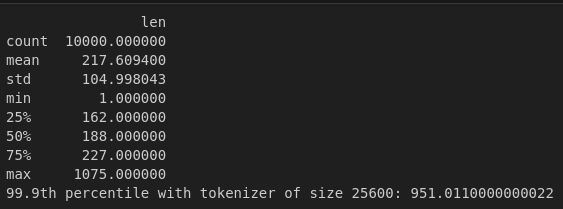

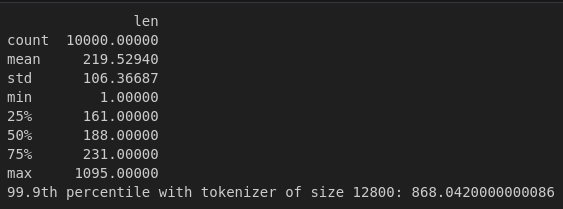

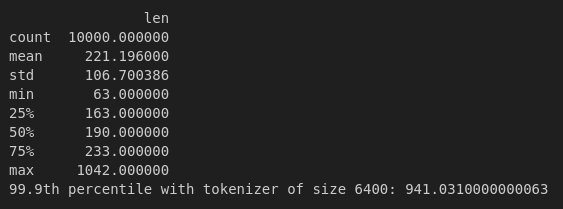

- While there's some randomness due to sample selection, it is clear that a tokenizer with vocab size of 6400 shall be sufficient to cover 99.9%+ of the cases if we choose sequence length of 1024 (a power of 2 to best work with GPU architecture).

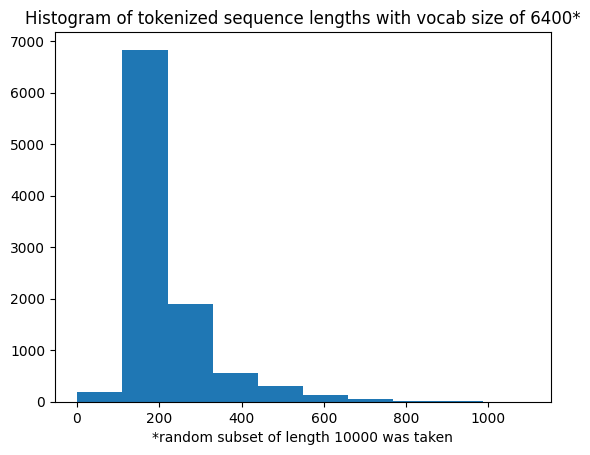

- Train with bs of 32 on 2 3090s with 150k tokens/second with vocab size of 6400; model size is about 91M due to lower vocab size.  Tops 18gb/gpu memory usage.
- torchrun --standalone --nproc_per_node=2 train_gpt2.py 

### After 250 steps

validation loss: 3.3220

rank 1 sample 0: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. As she watched the most important to leave, when it
rank 1 sample 1: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat.<|endoftext|>One day, Tom was a walk in the park
rank 1 sample 2: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. 

He looked up and he had a big field
rank 1 sample 3: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat.<|endoftext|>Once upon a time, there was a little girl
rank 0 sample 0: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat.

Then, he noticed some carrots where he went
rank 0 sample 1: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. He saw a big smile on his feet. The other
rank 0 sample 2: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. He was just have many food. But he ran up
rank 0 sample 3: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. They la

### After 500 steps

validation loss: 2.1717

rank 1 sample 0: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. When she arrived, she found a berry and took a
rank 1 sample 1: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. She decided to jump over the trees and jump over the
rank 1 sample 2: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. He spent every day looking for something to eat, but
rank 1 sample 3: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat.

One day the carrot was so filthy that it
rank 0 sample 0: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat.

As the rabbit was running, he began to
rank 0 sample 1: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. He felt so happy to have the special treat he took
rank 0 sample 2: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. The rabbit stopped to gather lots of juicy apples of apples
rank 0 sample 3: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. But something was different and it started to feel bored.

### After 750 steps
validation loss: 1.7123

rank 1 sample 0: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. The rabbit hopped around the forest looking for a berry,
rank 1 sample 1: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. But the rabbit got very hungry and the hunter was very
rank 1 sample 2: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. The rabbit searched everywhere for something to eat, but he
rank 1 sample 3: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. He enjoyed looking forward and collecting different carrots through the forest
rank 0 sample 0: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. He searched under the tall trees, until he found a
rank 0 sample 1: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. One day, the rabbit found some good berries in the
rank 0 sample 2: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. One day, he decided to go searching for nuts.
rank 0 sample 3: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. The rabbit was very happy and hopped around the forest looking

### After 1000 steps
validation loss: 1.5746

rank 1 sample 0: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. He was so excited about his reward! 

As
rank 1 sample 1: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. Every morning the rabbit would go out searching for something to
rank 1 sample 2: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. The rabbit had to find a big, juicy carrot and
rank 1 sample 3: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. He hopped around all the sights until he found a big
rank 0 sample 0: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. He hopped off the trail and went back to his den
rank 0 sample 1: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. One day, the rabbit came across a big tree with
rank 0 sample 2: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. One day, he came across a pond and had a
rank 0 sample 3: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. As he was hopping around, the rabbit saw a big

## Generate from the model

In [1]:
import torch
from train_gpt2 import GPT, GPTConfig

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")
# # model = GPT(GPTConfig(vocab_size=6400))
# # state_dict=torch.load('log/model_00999.pt')['model']
# # model.load_state_dict(state_dict)

# checkpoint = torch.load('log/model_00999.pt')

# # Extract the config from the checkpoint
# ckpt = checkpoint['config']['model']

# # Initialize the model with the saved config
# model = GPT(config)

# # Load the state dict into the model
# model.load_state_dict(ckpt)#checkpoint['model'])
# model.eval()
# model.to(device)




device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

# Load the checkpoint
checkpoint = torch.load('log/model_00999.pt', map_location=device)

# Extract the config from the checkpoint
config = checkpoint['config']

# Initialize the model with the saved config
model = GPT(config)

# Load the state dict into the model
model.load_state_dict(checkpoint['model'])
model.eval()
model.to(device)

print("Model loaded successfully and set to evaluation mode.")

using device: cuda:0
using device: cuda:0
Model loaded successfully and set to evaluation mode.


In [11]:
import torch.nn.functional as F
from transformers import AutoTokenizer
num_return_sequences = 4
max_length = 233
device_type = device
tokenizer = enc = AutoTokenizer.from_pretrained("tokenizer/tiny_stories_tokenizer")
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
tokenizer.pad_token = tokenizer.eos_token
#starter_txt="Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat."
starter_txt = "Once upon a time"
tokens = enc.encode(starter_txt)
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
xgen = tokens.to(device)
sample_rng = torch.Generator(device=device)
sample_rng.manual_seed(42)

while xgen.size(1) < max_length:
    # forward the model to get the logits
    with torch.no_grad():
        #with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
        logits, loss = model(xgen) # (B, T, vocab_size)
        # take the logits at the last position
        logits = logits[:, -1, :] # (B, vocab_size)
        # get the probabilities
        probs = F.softmax(logits, dim=-1)
        # do top-k sampling of 50 (huggingface pipeline default)
        # topk_probs here becomes (5, 50), topk_indices is (5, 50)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        # select a token from the top-k probabilities
        # note: multinomial does not demand the input to sum to 1
        ix = torch.multinomial(topk_probs, 1, generator=sample_rng) # (B, 1)
        # gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        # append to the sequence
        xgen = torch.cat((xgen, xcol), dim=1)
# print the generated text
for i in range(num_return_sequences):
    tokens = xgen[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print(f"sample {i}: {decoded}")

sample 0: Once upon a time, there was a boy named Max. Max loved to play with his toys and run around outside. One day, Max went to a big event where many people would gather around the house. The person in the audience wanted to play a game, but Max didn't want to play. Suddenly, he saw a little girl who was feeling sad. Max went to her and asked, "Do you want to play a game with me?" The little girl smiled and said, "Yes, let's play a game, that's very easy." They played a game of cards with toys. Max won the game and the little girl said, "Thank you for playing with me, Max!" Max felt happy that he made a new friend and they played together until the sun went down.<|endoftext|>Once upon a time, there was a little girl named Lily. She loved to bake cookies with her mommy. One day, they made a fancy cake that looked like a big star. 

Lily's mommy said, "Wow, this cake is very delicious! Did you bake it all by yourself?" 

Lily replied, "Yes, mommy
sample 1: Once upon a time there was